In [2]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import math
import os
import re
from gensim.models import word2vec
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import tempfile
import subprocess
import matplotlib.pyplot as plt 

RandomSeed = 42
np.random.seed(RandomSeed)


pd.set_option("display.max_colwidth", False)
pd.set_option('display.expand_frame_repr', False)
sns.set(font_scale = 1.2)

AA_array = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
       'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

kd = {"A": 1.8, "R": -4.5, "N": -3.5, "D": -3.5,
      "C": 2.5,  "Q": -3.5, "E": -3.5, "G": -0.4, "H": -3.2,
      "I": 4.5,
      "L": 3.8, "K": -3.9,
      "M": 1.9,
      "F": 2.8, "P": -1.6, "S": -0.8, "T": -0.7, "W": -0.9, "Y": -1.3,
      "V": 4.2} 


Hydrophobic_AAs = ['A', 'I', 'L', 'M', 'F', 'V']
Polar_AAs = ['S', 'Q', 'N', 'G', 'C', 'T', 'P']
Cation_AAs = ['K', 'R', 'H']
Anion_AAs = ['D', 'E']
Arom_AAs = ['W', 'Y', 'F']



def hydrophobicity(seq):
    sequence = ProteinAnalysis(seq)
    HB = 0
    for k in range(0, len(AA_array)):
        HB = HB + sequence.count_amino_acids()[AA_array[k]] * kd[AA_array[k]]        
    
    return HB


def Shannon_entropy(seq):
    sequence =  ProteinAnalysis(seq)
    entropy = 0
    for k in range(0, len(AA_array)):
        if sequence.get_amino_acids_percent()[AA_array[k]] == 0:
            entropy = entropy + 0
        else:
            entropy = entropy - math.log2(sequence.get_amino_acids_percent()[AA_array[k]]) * sequence.get_amino_acids_percent()[AA_array[k]]        
    
    return entropy




def extract_IDR(seq):
    tmp_IDR = tempfile.NamedTemporaryFile()  
    with open(tmp_IDR.name, 'w') as f_IDR:
         f_IDR.write('>1\n' + str(seq))
    tmp_IDR.seek(0)
    
    out = subprocess.Popen(['python', 'iupred2a.py', str(tmp_IDR.name), 'long'], 
           stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    stdout_IDR, stderr_IDR = out.communicate()
    stdout_IDR = stdout_IDR.split()[40:]
    
    IDR_prob = []
    for i in range(0, int(len(stdout_IDR)/3)):
        IDR_prob.append(float(str(stdout_IDR[3*i + 2], 'utf-8')))
       
    TH1 = 0.5
    TH2 = 20
    AAs   = pd.Series(list(map(lambda i:i, seq)))    
    IDR_residues = []
    current = 0
    for t in range(0, len(IDR_prob)):
        if IDR_prob[t] > TH1:
            current = current + 1
            if t == len(IDR_prob) - 1:
                if current > TH2:
                    IDR_residues.extend(range(t - current , t + 1))
        else:
            if current > TH2:
                IDR_residues.extend(range(t - current , t + 1))
                current = 0
            else:
                current = 0
    #IDR_seq = AAs[IDR_residues].str.cat()
    
    return len(IDR_residues)#, IDR_seq


def get_AA_count(seq, AA):
    if type(seq) == float:
        count = 0
    else:
        sequence = ProteinAnalysis(seq)
        count = sequence.count_amino_acids()[str(AA)]
    return count


def phys_features(sequence):
   # Evaluate sequence specific parameters that the model uses:
    df = pd.DataFrame({'Sequence' : [sequence]})
    df['Sequence_length'] = df['Sequence'].str.len()
    df['Hydrophobicity'] = hydrophobicity(str(df['Sequence']))
    df['Shannon_entropy'] = Shannon_entropy(str(df['Sequence'])) 
    
    IDR_reg = extract_IDR(df['Sequence'].item())
    #df['IDR_sequence']  = IDR_reg[1]
    df['IDR_fraction']  = IDR_reg / df['Sequence_length']
    
    # and also the amino acid composition specific features that the model uses:
    for k in range(0, len(AA_array)):
        df['AA_' + str(AA_array[k])] = [get_AA_count(seq, str(AA_array[k])) for seq in df['Sequence']]
    df['Polar'] = 0; df['Cation'] = 0; df['Arom'] = 0;
    for i in range(0, len(Polar_AAs)):
        df['Polar']  = df['Polar']  + df['AA_' + str(Polar_AAs[i])]
    for i in range(0, len(Arom_AAs)):
        df['Arom']  = df['Arom']  + df['AA_' + str(Arom_AAs[i])]
    for i in range(0, len(Cation_AAs)):
        df['Cation']  = df['Cation']  + df['AA_' + str(Cation_AAs[i])]
    df = df.loc[:,~df.columns.str.startswith('AA_')]
    df['Polar_frac'] = (df['Polar']  / df["Sequence_length"]).replace(np.nan, 0)
    df['Cation_frac'] = (df['Cation']  / df["Sequence_length"]).replace(np.nan, 0)
    df['Arom_frac'] = (df['Arom']  / df["Sequence_length"] ).replace(np.nan, 0)
    
    df = df.drop(columns={'Polar', 'Arom', 'Cation'})
    
    return df



In [3]:
myseq = 'MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDTSGYGQSSYSSYGQSQNTGYGTQSTPQGYGSTGGYGSSQSSQSSYGQQSSYPGYGQQPAPSSTSGSYGSSSQSSSYGQPQSGSYSQQPSYGGQQQSYGQQQSYNPPQGYGQQNQYNSSSGGGGGGGGGGNYGQDQSSMSSGGGSGGGYGNQDQSGGGGSGGYGQQDRGGRGRGGSGGGGGGGGGGYNRSSGGYEPRGRGGGRGGRGGMGGSDRGGFNKFGGPRDQGSRHDSEQDNSDNNTIFVQGLGENVTIESVADYFKQIGIIKTNKKTGQPMINLYTDRETGKLKGEATVSFDDPPSAKAAIDWFDGKEFSGNPIKVSFATRRADFNRGGGNGRGGRGRGGPMGRGGYGGGGSGGGGRGGFPSGGGGGGGQQRAGDWKCPNPTCENMNFSWRNECNQCKAPKPDGPGGGPGGSHMGGNYGDDRRGGRGGYDRGGYRGRGGDRGGFRGGRGGGDRGGFGPGKMDSRGEHRQDRRERPY'
phys_features(myseq)

,Sequence,Sequence_length,Hydrophobicity,Shannon_entropy,IDR_fraction,Polar_frac,Cation_frac,Arom_frac
0,MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDTSGYGQSSYSSYGQSQNTGYGTQSTPQGYGSTGGYGSSQSSQSSYGQQSSYPGYGQQPAPSSTSGSYGSSSQSSSYGQPQSGSYSQQPSYGGQQQSYGQQQSYNPPQGYGQQNQYNSSSGGGGGGGGGGNYGQDQSSMSSGGGSGGGYGNQDQSGGGGSGGYGQQDRGGRGRGGSGGGGGGGGGGYNRSSGGYEPRGRGGGRGGRGGMGGSDRGGFNKFGGPRDQGSRHDSEQDNSDNNTIFVQGLGENVTIESVADYFKQIGIIKTNKKTGQPMINLYTDRETGKLKGEATVSFDDPPSAKAAIDWFDGKEFSGNPIKVSFATRRADFNRGGGNGRGGRGRGGPMGRGGYGGGGSGGGGRGGFPSGGGGGGGQQRAGDWKCPNPTCENMNFSWRNECNQCKAPKPDGPGGGPGGSHMGGNYGDDRRGGRGGYDRGGYRGRGGDRGGFRGGRGGGDRGGFGPGKMDSRGEHRQDRRERPY,526,-698.3,3.398065,0.89924,0.657795,0.102662,0.098859


In [4]:
df = pd.read_csv('w2v_nonnorm_LLPS_PDB_RF.csv', sep='\t')
df = df[(df['Category'] == 'LLPS+')]
df.drop_duplicates(subset ='Uniprot_ID', keep = 'first', inplace = True)
df.index = df['Uniprot_ID']
df=df.drop(['Uniprot_ID', 'Category'], axis = 1)
df.columns = ['LLPS_PDB_RF']
df

,LLPS_PDB_RF
Uniprot_ID,
Q9UHD9,1.000
P04147,1.000
Q13151,1.000
P22626,1.000
P09651-1,1.000
...,...
P08908,0.770
Q60598,0.745
Q41372,0.690


In [5]:
df1 = pd.read_csv('w2v_nonnorm_LLPS_LLPS_RF.csv', sep='\t')
df1 = df1[(df1['Category'] == 'LLPS+')]
df1.drop_duplicates(subset ='Uniprot_ID', keep = 'first', inplace = True)
df1.index = df1['Uniprot_ID']
df1=df1.drop(['Uniprot_ID', 'Category'], axis = 1)
df1.columns = ['LLPS_LLPS_RF']


In [6]:
df2 = pd.read_csv('Phys_features_LLPS_PDB_RF.csv', sep='\t')
df2 = df2[(df2['Category'] == 'LLPS+')]
df2.drop_duplicates(subset ='Uniprot_ID', keep = 'first', inplace = True)
df2.index = df2['Uniprot_ID']
df2=df2.drop(['Uniprot_ID', 'Category'], axis = 1)
df2.columns = ['Phys_feat_LLPS_PDB_RF']


In [7]:
df3 = pd.read_csv('Phys_features_LLPS_LLPS_RF.csv', '\t')
df3 = df3[(df3['Category'] == 'LLPS+')]
df3.drop_duplicates(subset ='Uniprot_ID', keep = 'first', inplace = True)
df3.index = df3['Uniprot_ID']
df3=df3.drop(['Category', 'Uniprot_ID'], axis = 1)
df3.columns = ['Phys_feat_LLPS_LLPS_RF']


In [8]:
exs = pd.read_excel('uniprot-filtered-organism__Homo+sapiens+(Human)+(9606)_+AND+review--.xlsx')
exs.index = exs['Entry']
exs = exs.drop(['Entry', 'Entry name', 'Protein names', 'Gene names', 'Status', 'Gene ontology (biological process)', 'Gene ontology (cellular component)', 'Gene ontology (molecular function)', 'Gene ontology (GO)', 'Gene ontology IDs'], axis=1)
exs

,Sequence
Entry,
Q8N7X0,MASKQTKKKEVHRINSAHGSDKSKDFYPFGSNVQSGSTEQKKGKFPLWPEWSEADINSEKWDAGKGAKEKDKTGKSPVFHFFEDPEGKIELPPSLKIYSWKRPQDILFSQTPVVVKNEITFDLFSANEHLLCSELMRWIISEIYAVWKIFNGGILSNYFKGTSGEPPLLPWKPWEHIYSLCKAVKGHMPLFNSYGKYVVKLYWMGCWRKITIDDFLPFDEDNNLLLPATTYEFELWPMLLSKAIIKLANIDIHVADRRELGEFTVIHALTGWLPEVISLHPGYMDKVWELLKEILPEFKLSDEASSESKIAVLDSKLKEPGKEGKEGKEIKDGKEVKDVKEFKPESSLTTLKAPEKSDKVPKEKADARDIGKKRSKDGEKEKFKFSLHGSRPSSEVQYSVQSLSDCSSAIQTSHMVVYATFTPLYLFENKIFSLEKMADSAEKLREYGLSHICSHPVLVTRSRSCPLVAPPKPPPLPPWKLIRQKKETVITDEAQELIVKKPERFLEISSPFLNYRMTPFTIPTEMHFVRSLIKKGIPPGSDLPSVSETDETATHSQTDLSQITKATSQGNTASQVILGKGTDEQTDFGLGDAHQSDGLNLEREIVSQTTATQEKSQEELPTTNNSVSKEIWLDFEDFCVCFQNIYIFHKPSSYCLNFQKSEFKFSEERVSYYLFVDSLKPIELLVCFSALVRWGEYGALTKDSPPIEPGLLTAETFSWKSLKPGSLVLKIHTYATKATVVRLPVGRHMLLFNAYSPVGHSIHICSMVSFVIGDEHVVLPNFEPESCRFTEQSLLIMKAIGNVIANFKDKGKLSAALKDLQTAHYPVPFHDKELTAQHFRVFHLSLWRLMKKVQITKPPPNFKFAFRAMVLDLELLNSSLEEVSLVEWLDVKYCMPTSDKEYSAEEVAAAIKIQAMWRGTYVRLLMKARIPDTKENISVADTLQKVWAVLEMNLEQYAVSLLRLMFKSKCKSLESYPCYQDEETKIAFADYTVTYQEQPPNSWFIVFRETFLVHQDMILVPKVYTTLPICILHIVNNDTMEQVPKVFQKVVPYLYTKNKKGYTFVAEAFTGDTYVAASRWKLRLIGSSAPLPCLSRDSPCNSFAIKEIRDYYIPNDKKILFRYSVKVLTPQPATIQVRTSKPDAFIKLQVLENEETMVSSTGKGQAIIPAFHFLKSEKGLSSQSSKHILSFHSASKKEQEVYVKKKAAQGIQKSPKGRAVSAIQDIGLPLVEEETTSTPTREDSSSTPLQNYKYIIQCSVLYNSWPLTESQLTFVQALKDLKKSNTKAYGERHEELINLGSPDSHTISEGQKSSVTSKTTRKGKEKSSEKEKTAKEKQAPRFEPQISTVHPQQEDPNKPYWILRLVTEHNESELFEVKKDTERADEIRAMKQAWETTEPGRAIKASQARLHYLSGFIKKTSDAESPPISESQTKPKEEVETAARGVKEPNSKNSAGSESKEMTQTGSGSAVWKKWQLTKGLRDVAKSTSSESGGVSSPGKEEREQSTRKENIQTGPRTRSPTILETSPRLIRKALEFMDLSQYVRKTDTDPLLQTDELNQQQAMQKAEEIHQFRQHRTRVLSIRNIDQEERLKLKDEVLDMYKEMQDSLDEARQKIFDIREEYRNKLLEAEHLKLETLAAQEAAMKLETEKMTPAPDTQKKKKGKKK
Q5T1N1,MDEADFSEHTTYKQEDLPYDGDLSQIKIGNDYSFTSKKDGLEVLNQIIFIADDPQEKAMHSETCGNTAVTIPLGKITENAANKKDEKEKQCTAALHIPANEGDASKSSISDILLHHLSKEPFLRGQGIDCETLPEISNADSFEEEAIIKSIISCYNKNSWPKEQTPELTDQLNPKRDGENSNKPGSATTTEENTSDLEGPVAAGDSSHQENVNVLTKTKGPGDKQKSYQGQSPQKQQTEKANSGNTFKYGQGQVHYQLPDFSKIAPKVKIPKNKIINKPLAIAKQASFSSKSRDKPTLVQDSLETTPESNCVEKQHQEQKGKITEPSQQIQMEPIVHIHQELLTGIESEASLSKLSPTSQKGTSSSSSYIFQKISQGKQMCQKLKEQTDQLKTKVQEFSKRIKQDSPYHLQDKKLVLEKLQGHLELLEQNFLATKDKHLTLQQQVHKHESTIVGDFDPERKVEGEIFKLEMLLEDVKEKMDESKYTSAPSLPVSSPVTLDDLASTFSSLSNEIPKEHPGHPSGPRGSGGSEVTGTPQGGPQEAPNEELCELAPQTYLNGHYGDAAAQNKPDQVAMRLSSNSGEDPNGTPRRQDCAEMTAPSPSCAFCRRLLEWKQNVEKKGHGRINCGRFSIVLHEKAPHSDSTPNSDTGHSFCSDSGTEMQSNKCQDCGTKIPTSRRACRKEPTKEFHYRYNTPGQNYSNHSKRGAFVQPHSLDESKNSSPSFLKPKRICSQRVNSKSFKGEHEPTPGKKKLQAFMTYSSDPATPSPHFYSCRISGSKSLCDFDSTEEIKSEILNSALDHALRTATILKETTDQMIKTIAEDLAKAQRWRNRLKY
Q92667,MAIQFRSLFPLALPGMLALLGWWWFFSRKKGHVSSHDEQQVEAGAVQLRADPAIKEPLPVEDVCPKVVSTPPSVTEPPEKELSTVSKLPAEPPALLQTHPPCRRSESSGILPNTTDMRLRPGTRRDDSTKLELALTGGEAKSIPLECPLSSPKGVLFSSKSAEVCKQDSPFSRVPRKVQPGYPVVPAEKRSSGERARETGGAEGTGDAVLGEKVLEEALLSREHVLELENSKGPSLASLEGEEDKGKSSSSQVVGPVQEEEYVAEKLPSRFIESAHTELAKDDAAPAPPVADAKAQDRGVEGELGNEESLDRNEEGLDRNEEGLDRNEESLDRNEEGLDRNEEIKRAAFQIISQVISEATEQVLATTVGKVAGRVCQASQLQGQKEESCVPVHQKTVLGPDTAEPATAEAAVAPPDAGLPLPGLPAEGSPPPKTYVSCLKSLLSSPTKDSKPNISAHHISLASCLALTTPSEELPDRAGILVEDATCVTCMSDSSQSVPLVASPGHCSDSFSTSGLEDSCTETSSSPRDKAITPPLPESTVPFSNGVLKGELSDLGAEDGWTMDAEADHSGGSDRNSMDSVDSCCSLKKTESFQNAQAGSNPKKVDLIIWEIEVPKHLVGRLIGKQGRYVSFLKQTSGAKIYISTLPYTQSVQICHIEGSQHHVDKALNLIGKKFKELNLTNIYAPPLPSLALPSLPMTSWLMLPDGITVEVIVVNQVNAGHLFVQQHTHPTFHALRSLDQQMYLCYSQPGIPTLPTPVEITVICAAPGADGAWWRAQVVASYEETNEVEIRYVDYGGYKRVKVDVLRQIRSDFVTLPFQGAEVLLDSVMPLSDDDQFSPEADAAMSEMTGNTALLAQVTSYSPTGLPLIQLWSVVGDEVVLINRSLVERGLAQWVDSYYTSL
Q5VUY0,MWDLALIFLAAACVFSLGVTLWVICSHFFTVHIPAAVGHPVKLRVLHCIFQLLLTWGMIFEKLRICSMPQFFCFMQDLPPLKYDPDVVVTDFRFGTIPVKLYQPKASTCTLKPGIVYYHGGGGVMGSLKTHHGICSRLCKESDSVVLAVGYRKLPKHKFPVPVRDCLVATIHFLKSLDAYGVDPARVVVCGDSFGGAIAAVVCQQLVDRPDLPRIRAQILIYAILQALDLQTPSFQQRKNIPLLTWSFICYFFFQNLDFSSSWQEVIMKGAHLPAEVWEKYRKWLGPENIPERFKERGYQLKPHEPMNEAAYLEVSVVLDVMCSPLIAEDDIVSQLPETCIVSCEYDALRDNSLLYKKRLEDLGVPVTWHHMEDGFHGVLRTIDMSFLHFPCSMRILSALVQFVKGL
P62736,MCEEEDSTALVCDNGSGLCKAGFAGDDAPRAVFPSIVGRPRHQGVMVGMGQKDSYVGDEAQSKRGILTLKYPIEHGIITNWDDMEKIWHHSFYNELRVAPEEHPTLLTEAPLNPKANREKMTQIMFETFNV

In [9]:
df=df.join(df3, how='outer')

In [10]:
idx1 = df.index.unique()
idx2 = exs.index.unique()
a = idx2.intersection(idx1)
a

Index(['P17600', 'Q13151', 'Q92777', 'Q13148', 'P08908', 'P31942', 'Q14103',
       'Q01844', 'P24928', 'P01106', 'P10275', 'P55795', 'Q9H9S0', 'P06748',
       'Q32P51', 'Q8WXF1', 'P04156', 'P51991', 'Q15648', 'P33240', 'O14979',
       'P48431', 'P10276', 'P22626', 'P03372', 'Q9H0L4', 'Q14781', 'P45973',
       'P35637', 'P31483', 'Q9UHD9', 'O60885', 'P15502', 'Q01085', 'Q9UER7'],
      dtype='object')

In [11]:
df3=exs.loc[a]
sequences = df3['Sequence'].tolist()

In [12]:
temp_c = [phys_features(t) for t in sequences]
temp_c_df = pd.concat(temp_c)
temp_c_df.index = df3.index
temp_c_df = temp_c_df.drop(['Sequence'], axis=1)
temp_c_df

,Sequence_length,Hydrophobicity,Shannon_entropy,IDR_fraction,Polar_frac,Cation_frac,Arom_frac
P17600,705,-447.3,3.855106,0.523404,0.492199,0.123404,0.051064
Q13151,305,-185.4,3.542060,0.236066,0.485246,0.137705,0.101639
Q92777,582,-265.8,3.937008,0.393471,0.431271,0.118557,0.073883
Q13148,414,-225.6,3.907539,0.212560,0.446860,0.108696,0.086957
P08908,422,78.1,3.934198,0.063981,0.355450,0.118483,0.085308
P31942,346,-258.4,3.650878,0.000000,0.433526,0.132948,0.118497
Q14103,355,-332.2,3.789595,0.270423,0.416901,0.143662,0.112676
Q01844,656,-737.0,3.669300,0.842988,0.596037,0.102134,0.091463
P24928,1970,-1056.3,4.076700,0.235025,0.439594,0.124365,0.079188
P01106,439,-343.2,3.861992,0.325740,0.416856,0.136674,0.061503


In [62]:
temp_c_df.style.bar(align='mid', color=['red', 'lightgreen'])


,Sequence_length,Hydrophobicity,Shannon_entropy,IDR_fraction,Polar_frac,Cation_frac,Arom_frac
P17600,705,-447.300000,3.855106,0.523404,0.492199,0.123404,0.051064
Q13151,305,-185.400000,3.542060,0.236066,0.485246,0.137705,0.101639
Q92777,582,-265.800000,3.937008,0.393471,0.431271,0.118557,0.073883
Q13148,414,-225.600000,3.907539,0.212560,0.446860,0.108696,0.086957
P08908,422,78.100000,3.934198,0.063981,0.355450,0.118483,0.085308
P31942,346,-258.400000,3.650878,0.000000,0.433526,0.132948,0.118497
Q14103,355,-332.200000,3.789595,0.270423,0.416901,0.143662,0.112676
Q01844,656,-737.000000,3.669300,0.842988,0.596037,0.102134,0.091463
P24928,1970,-1056.300000,4.076700,0.235025,0.439594,0.124365,0.079188
P01106,439,-343.200000,3.861992,0.325740,0.416856,0.136674,0.061503


In [15]:
with open('nw.pkl', 'rb') as f:
    mynewlist = pickle.load(f)

In [16]:
df4=exs.loc[mynewlist]
test_seq = df4['Sequence'].tolist()

In [64]:
test = [phys_features(t) for t in test_seq]
test_df = pd.concat(test)
test_df.index = df4.index
test_df = test_df.drop(['Sequence'], axis=1)
test_df.style.bar(align='mid', color=['red', 'lightgreen'])

,Sequence_length,Hydrophobicity,Shannon_entropy,IDR_fraction,Polar_frac,Cation_frac,Arom_frac
Entry,,,,,,,
O15116,133,-48.800000,3.427337,0.000000,0.263158,0.157895,0.045113
O43561,262,-115.900000,3.656444,0.648855,0.423664,0.072519,0.061069
O43663,620,-447.400000,3.936272,0.246774,0.324194,0.170968,0.056452
O43791,374,-95.500000,3.921510,0.000000,0.310160,0.136364,0.090909
O43809,227,-94.100000,3.775225,0.000000,0.352423,0.140969,0.114537
O60832,514,-252.500000,3.908049,0.192607,0.285992,0.204280,0.048638
O75494,262,-465.900000,3.508575,0.679389,0.385496,0.297710,0.099237
O75683,361,-497.600000,3.534777,0.750693,0.265928,0.285319,0.024931
O75791,330,-278.400000,3.895171,0.390909,0.366667,0.169697,0.096970


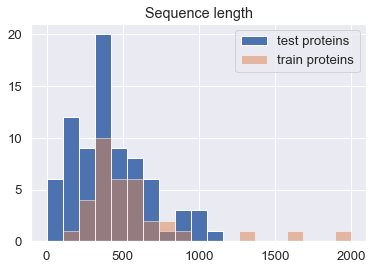

In [20]:
x = [test_df['Sequence_length']]
y = [temp_c_df['Sequence_length']]

bins = np.linspace(-0.001, 2000, 20)

plt.hist(x, bins, alpha=1, label='test proteins')
plt.hist(y, bins, alpha=0.5, label='train proteins')
plt.legend(loc='upper right')
plt.title('Sequence length')
plt.show()

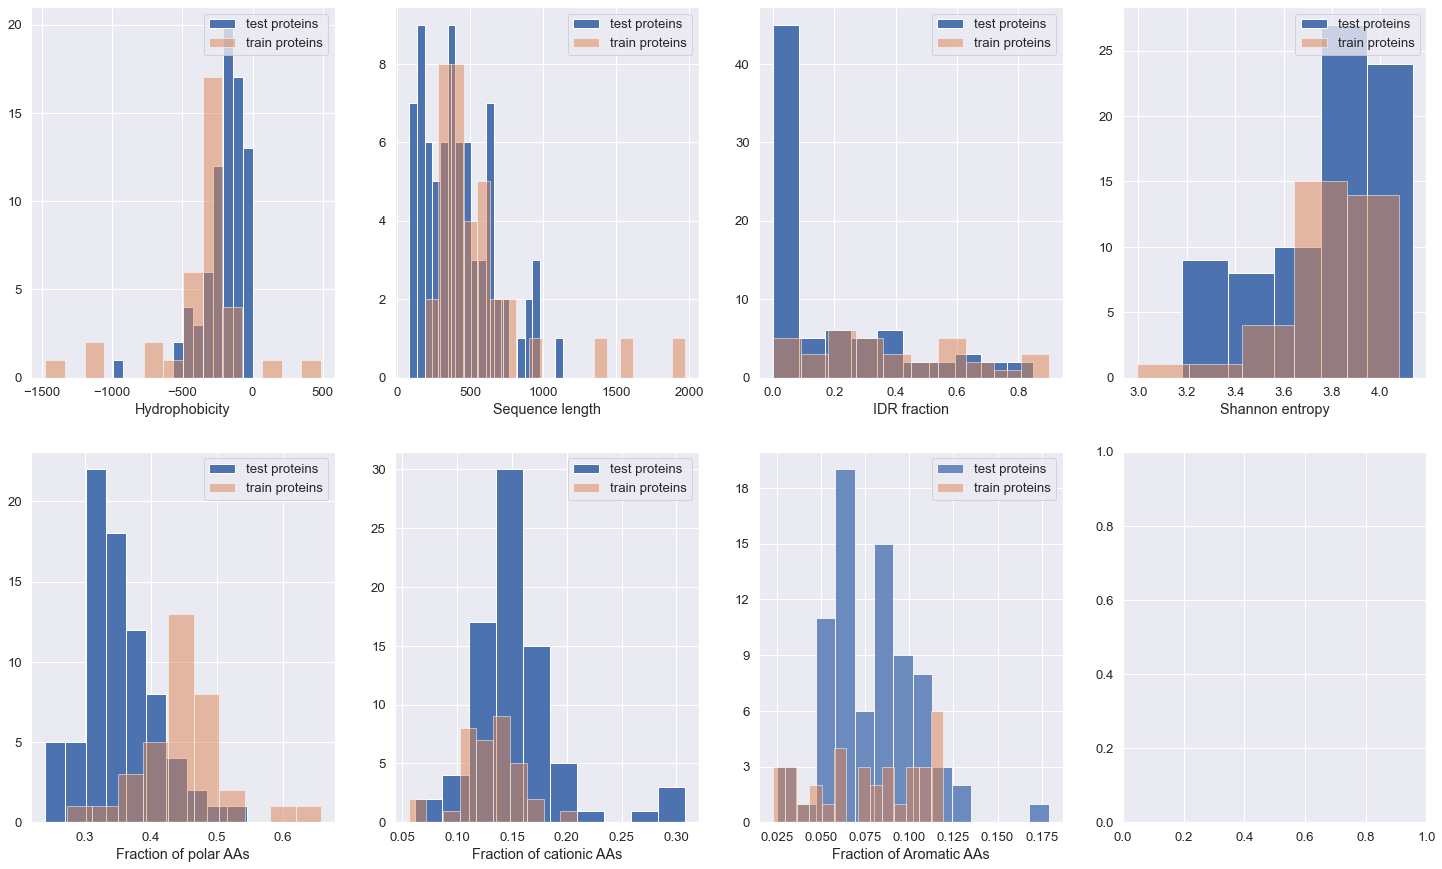

In [21]:
x = [10,10,10,10,20,20,20,30,30,40]
y = [40,40,40,40,30,30,30,20,20,10]
fig, ax = plt.subplots(2, 4, figsize = (25,15))

ax[0][0].hist([test_df['Hydrophobicity']], bins=14, alpha=1, label='test proteins')
ax[0][0].hist([temp_c_df['Hydrophobicity']], bins=14, alpha=0.5, label='train proteins')
ax[0][0].legend(loc='upper right')
ax[0][0].set_xlabel('Hydrophobicity')
ax[0][0].set_yticks([0,5,10,15,20])

ax[0][1].hist([test_df['Sequence_length']], bins=20, alpha=1, label='test proteins')
ax[0][1].hist([temp_c_df['Sequence_length']], bins=20, alpha=0.5, label='train proteins')
ax[0][1].legend(loc='upper right')
ax[0][1].set_xlabel('Sequence length')

ax[0][2].hist([test_df['IDR_fraction']], bins=10, alpha=1, label='test proteins')
ax[0][2].hist([temp_c_df['IDR_fraction']], bins=10, alpha=0.5, label='train proteins')
ax[0][2].legend(loc='upper right')
ax[0][2].set_xlabel('IDR fraction')

ax[0][3].hist([test_df['Shannon_entropy']], bins=5, alpha=1, label='test proteins')
ax[0][3].hist([temp_c_df['Shannon_entropy']], bins=5, alpha=0.5, label='train proteins')
ax[0][3].legend(loc='upper right')
ax[0][3].set_xlabel('Shannon entropy')

ax[1][0].hist([test_df['Polar_frac']], bins=10, alpha=1, label='test proteins')
ax[1][0].hist([temp_c_df['Polar_frac']], bins=10, alpha=0.5, label='train proteins')
ax[1][0].legend(loc='upper right')
ax[1][0].set_xlabel('Fraction of polar AAs')

ax[1][1].hist([test_df['Cation_frac']], bins=10, alpha=1, label='test proteins')
ax[1][1].hist([temp_c_df['Cation_frac']], bins=10, alpha=0.5, label='train proteins')
ax[1][1].legend(loc='upper right')
ax[1][1].set_xlabel('Fraction of cationic AAs')

ax[1][2].hist([test_df['Arom_frac']], bins=14, alpha=0.8, label='test proteins')
ax[1][2].hist([temp_c_df['Arom_frac']], bins=14, alpha=0.5, label='train proteins')
ax[1][2].legend(loc='upper right')
ax[1][2].set_xlabel('Fraction of Aromatic AAs')
ax[1][2].set_yticks([0,3,6,9,12,15,18])



plt.savefig('physical features.png', bbox_inches='tight', pad_inches = 0.0)
plt.show()

In [22]:
train_percentiles=np.percentile(temp_c_df['Sequence_length'], range(0,101))

In [23]:
def percentilator(s, lst):
    left = 0
    right=len(lst)-1
    center = (left+right)//2
    
    if s>lst[right]:
        return '100%'
    elif s<lst[left]:
        return '-1%'
    if s==lst[center]:
        return center
    
    while left<center:
        if s ==lst[center]:
            return center
        elif s>lst[center]:
            left=center
        else:
            right=center
        center = (left+right)//2
    return center

In [24]:
train_df=pd.DataFrame(temp_c_df)
train_dict={}

columns = list(train_df) 
for i in columns:
    train_dict[i]=np.percentile(train_df[i], range(0,101))
    
train_dict

{'Sequence_length': array([ 191.  ,  212.08,  233.16,  253.82,  267.76,  281.7 ,  294.44,
         298.18,  301.92,  305.  ,  305.  ,  305.  ,  305.96,  310.04,
         314.12,  317.3 ,  318.32,  319.34,  323.12,  331.96,  340.8 ,
         346.98,  349.36,  351.74,  353.32,  354.  ,  354.68,  358.6 ,
         365.4 ,  372.2 ,  375.6 ,  376.62,  377.64,  379.76,  382.48,
         385.2 ,  392.72,  402.24,  411.76,  415.56,  417.6 ,  419.64,
         420.56,  421.24,  421.92,  427.1 ,  432.88,  438.66,  442.2 ,
         445.6 ,  449.  ,  453.42,  457.84,  463.22,  483.96,  504.7 ,
         523.12,  524.14,  525.16,  526.36,  528.4 ,  530.44,  535.6 ,
         550.9 ,  566.2 ,  577.5 ,  579.2 ,  580.9 ,  583.56,  587.98,
         592.4 ,  597.94,  605.08,  612.22,  617.28,  620.  ,  622.72,
         629.76,  640.64,  651.52,  665.8 ,  682.46,  699.12,  712.7 ,
         724.6 ,  736.5 ,  751.04,  766.68,  782.32,  820.84,  866.4 ,
         911.96, 1043.76, 1194.04, 1344.32, 1427.7 , 1502.

In [79]:
test_df1=pd.DataFrame(test_df)

columns = list(train_df) 
for i in columns:
    test_df1[i] = test_df1[i].apply(lambda x: percentilator(x, train_dict[i]))
test_df1

,Sequence_length,Hydrophobicity,Shannon_entropy,IDR_fraction,Polar_frac,Cation_frac,Arom_frac
Entry,,,,,,,
O15116,-1%,95,3,0,-1%,86,23
O43561,3,94,18,88,27,4,34
O43663,75,20,80,38,2,97,28
O43791,29,94,75,0,2,55,61
O43809,1,94,33,0,5,66,90
...,...,...,...,...,...,...,...
Q9Y333,-1%,95,2,0,1,59,55
Q9Y4Y9,-1%,96,1,0,5,5,8
Q9Y4Z0,-1%,94,5,58,24,98,26


In [92]:
pluses=pd.read_csv('pluses.csv')
pluses=pluses.rename(columns = {'Unnamed: 0':'Entry'})
pluses.index=pluses['Entry']
pluses=pluses.drop(['Entry'], axis=1)
pluses

,w2v_LLPS_PDB_RF,Phys_feat_LLPS_PDB_RF,w2v_LLPS_LLPS_RF,Phys_feat_LLPS_LLPS_RF
Entry,,,,
O00401,+,+,+,+
O14641,+,+,+,+
O15116,-,-,-,-
O15169,+,+,+,+
O15550,+,+,+,+
...,...,...,...,...
Q9Y3R0,+,+,+,+
Q9Y4Y9,-,-,+,-
Q9Y4Z0,-,+,-,-


In [94]:
result=pd.merge(test_df1, pluses, on='Entry')
result.to_csv('pluses_minuses.csv')

In [26]:
test_df1.to_csv('percentiles.csv')

In [27]:
with open('work.pkl', 'rb') as f:
    mynewlist1 = pickle.load(f)

In [65]:
df5=exs.loc[mynewlist1]
wtest_seq = df5['Sequence'].tolist()

wtest = [phys_features(t) for t in wtest_seq]
wtest_df = pd.concat(wtest)
wtest_df.index = df5.index
wtest_df = wtest_df.drop(['Sequence'], axis=1)
wtest_df.style.bar(align='mid', color=['red', 'lightgreen'])

,Sequence_length,Hydrophobicity,Shannon_entropy,IDR_fraction,Polar_frac,Cation_frac,Arom_frac
Entry,,,,,,,
O00401,505,-426.200000,3.846972,0.704950,0.465347,0.134653,0.053465
O14641,736,-421.300000,3.911254,0.464674,0.449728,0.119565,0.063859
O15169,862,-688.600000,4.007694,0.548724,0.370070,0.172854,0.062645
O15550,1401,-647.500000,4.096787,0.336188,0.434690,0.122769,0.072805
O43390,633,-594.800000,3.950264,0.325434,0.368088,0.161137,0.099526
O43670,478,-309.100000,3.758483,0.845188,0.525105,0.106695,0.043933
O43781,588,-266.800000,4.028148,0.159864,0.375850,0.170068,0.079932
O60479,287,-245.800000,3.727461,0.439024,0.473868,0.125436,0.101045
O75177,396,-405.600000,3.541574,0.828283,0.601010,0.060606,0.090909


In [30]:
with open('all.pkl', 'rb') as f:
    mynewlist2 = pickle.load(f)

In [66]:
df6=exs.loc[mynewlist2]
test_all = df6['Sequence'].tolist()

test = [phys_features(t) for t in test_all]
test_all = pd.concat(test)
test_all.index = df6.index
test_all = test_all.drop(['Sequence'], axis=1)
test_all.style.bar(align='mid', color=['red', 'lightgreen'])

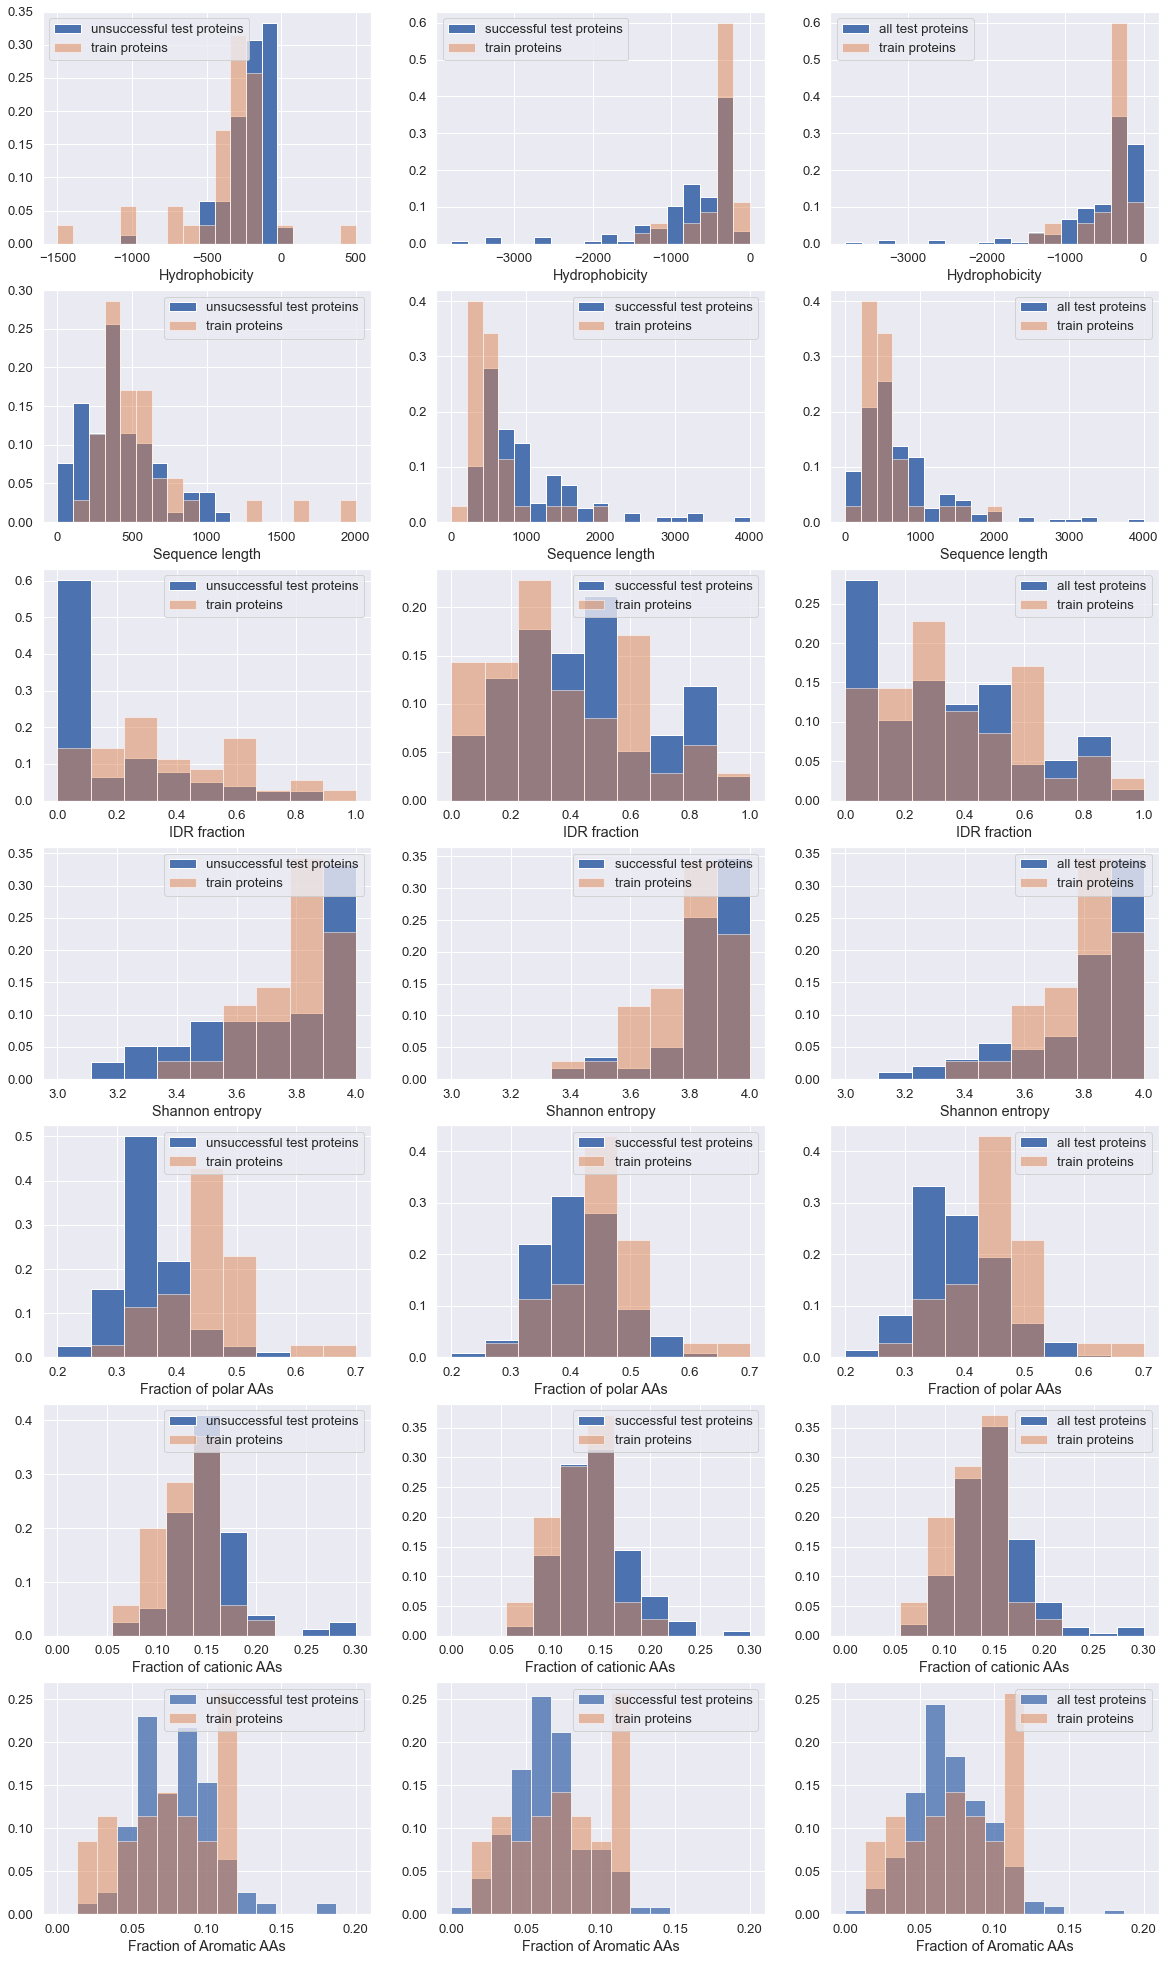

In [76]:
fig, ax = plt.subplots(7, 3, figsize = (20,35))

bins = np.linspace(-0.001, 2000, 20)
bins1 = np.linspace(-0.001, 4000, 20)
binsh=np.linspace(-1500, 500, 20)
binsh1=np.linspace(-3800,0,19)
bins_IDR=np.linspace(0,1,10)
binss=np.linspace(3,4,10)
binsp=np.linspace(0.2,0.7,10)
binsc=np.linspace(0,0.3,12)
binsa=np.linspace(0,0.2,16)


ax[0][0].hist([test_df['Hydrophobicity']], binsh, weights=np.ones(len(test_df['Hydrophobicity'])) / len(test_df['Hydrophobicity']), alpha=1, label='unsuccessful test proteins')
ax[0][0].hist([temp_c_df['Hydrophobicity']], binsh, weights=np.ones(len(temp_c_df['Hydrophobicity'])) / len(temp_c_df['Hydrophobicity']), alpha=0.5, label='train proteins')
ax[0][0].legend(loc='upper left')
ax[0][0].set_xlabel('Hydrophobicity')


ax[0][1].hist([wtest_df['Hydrophobicity']], binsh1, weights=np.ones(len(wtest_df['Hydrophobicity'])) / len(wtest_df['Hydrophobicity']), alpha=1, label='successful test proteins')
ax[0][1].hist([temp_c_df['Hydrophobicity']], binsh1, weights=np.ones(len(temp_c_df['Hydrophobicity'])) / len(temp_c_df['Hydrophobicity']), alpha=0.5, label='train proteins')
ax[0][1].legend(loc='upper left')
ax[0][1].set_xlabel('Hydrophobicity')


ax[0][2].hist([test_all['Hydrophobicity']], binsh1, weights=np.ones(len(test_all['Hydrophobicity'])) / len(test_all['Hydrophobicity']), alpha=1, label='all test proteins')
ax[0][2].hist([temp_c_df['Hydrophobicity']], binsh1, weights=np.ones(len(temp_c_df['Hydrophobicity'])) / len(temp_c_df['Hydrophobicity']), alpha=0.5, label='train proteins')
ax[0][2].legend(loc='upper left')
ax[0][2].set_xlabel('Hydrophobicity')


ax[1][0].hist([test_df['Sequence_length']], bins, weights=np.ones(len(test_df['Sequence_length'])) / len(test_df['Sequence_length']), alpha=1, label='unsucsessful test proteins')
ax[1][0].hist([temp_c_df['Sequence_length']], bins, weights=np.ones(len(temp_c_df['Sequence_length'])) / len(temp_c_df['Sequence_length']), alpha=0.5, label='train proteins')
ax[1][0].legend(loc='upper right')
ax[1][0].set_xlabel('Sequence length')

ax[1][1].hist([wtest_df['Sequence_length']], bins1, weights=np.ones(len(wtest_df['Sequence_length'])) / len(wtest_df['Sequence_length']),alpha=1, label='successful test proteins')
ax[1][1].hist([temp_c_df['Sequence_length']], bins1, weights=np.ones(len(temp_c_df['Sequence_length'])) / len(temp_c_df['Sequence_length']),alpha=0.5, label='train proteins')
ax[1][1].legend(loc='upper right')
ax[1][1].set_xlabel('Sequence length')

ax[1][2].hist([test_all['Sequence_length']], bins1, weights=np.ones(len(test_all['Sequence_length'])) / len(test_all['Sequence_length']),alpha=1, label='all test proteins')
ax[1][2].hist([temp_c_df['Sequence_length']], bins1, weights=np.ones(len(temp_c_df['Sequence_length'])) / len(temp_c_df['Sequence_length']),alpha=0.5, label='train proteins')
ax[1][2].legend(loc='upper right')
ax[1][2].set_xlabel('Sequence length')

ax[2][0].hist([test_df['IDR_fraction']], bins_IDR, weights=np.ones(len(test_df['IDR_fraction'])) / len(test_df['IDR_fraction']),alpha=1, label='unsuccessful test proteins')
ax[2][0].hist([temp_c_df['IDR_fraction']], bins_IDR, weights=np.ones(len(temp_c_df['IDR_fraction'])) / len(temp_c_df['IDR_fraction']),alpha=0.5, label='train proteins')
ax[2][0].legend(loc='upper right')
ax[2][0].set_xlabel('IDR fraction')

ax[2][1].hist([wtest_df['IDR_fraction']], bins_IDR, weights=np.ones(len(wtest_df['IDR_fraction'])) / len(wtest_df['IDR_fraction']), alpha=1, label='successful test proteins')
ax[2][1].hist([temp_c_df['IDR_fraction']], bins_IDR, weights=np.ones(len(temp_c_df['IDR_fraction'])) / len(temp_c_df['IDR_fraction']), alpha=0.5, label='train proteins')
ax[2][1].legend(loc='upper right')
ax[2][1].set_xlabel('IDR fraction')

ax[2][2].hist([test_all['IDR_fraction']], bins_IDR, weights=np.ones(len(test_all['IDR_fraction'])) / len(test_all['IDR_fraction']),alpha=1, label='all test proteins')
ax[2][2].hist([temp_c_df['IDR_fraction']], bins_IDR, weights=np.ones(len(temp_c_df['IDR_fraction'])) / len(temp_c_df['IDR_fraction']),alpha=0.5, label='train proteins')
ax[2][2].legend(loc='upper right')
ax[2][2].set_xlabel('IDR fraction')

ax[3][0].hist([test_df['Shannon_entropy']], binss, weights=np.ones(len(test_df['Shannon_entropy'])) / len(test_df['Shannon_entropy']),alpha=1, label='unsuccessful test proteins')
ax[3][0].hist([temp_c_df['Shannon_entropy']], binss, weights=np.ones(len(temp_c_df['Shannon_entropy'])) / len(temp_c_df['Shannon_entropy']), alpha=0.5, label='train proteins')
ax[3][0].legend(loc='upper right')
ax[3][0].set_xlabel('Shannon entropy')

ax[3][1].hist([wtest_df['Shannon_entropy']], binss, weights=np.ones(len(wtest_df['Shannon_entropy'])) / len(wtest_df['Shannon_entropy']),alpha=1, label='successful test proteins')
ax[3][1].hist([temp_c_df['Shannon_entropy']], binss, weights=np.ones(len(temp_c_df['Shannon_entropy'])) / len(temp_c_df['Shannon_entropy']),alpha=0.5, label='train proteins')
ax[3][1].legend(loc='upper right')
ax[3][1].set_xlabel('Shannon entropy')

ax[3][2].hist([test_all['Shannon_entropy']], binss, weights=np.ones(len(test_all['Shannon_entropy'])) / len(test_all['Shannon_entropy']),alpha=1, label='all test proteins')
ax[3][2].hist([temp_c_df['Shannon_entropy']], binss, weights=np.ones(len(temp_c_df['Shannon_entropy'])) / len(temp_c_df['Shannon_entropy']),alpha=0.5, label='train proteins')
ax[3][2].legend(loc='upper right')
ax[3][2].set_xlabel('Shannon entropy')

ax[4][0].hist([test_df['Polar_frac']], binsp, weights=np.ones(len(test_df['Polar_frac'])) / len(test_df['Polar_frac']), alpha=1, label='unsuccessful test proteins')
ax[4][0].hist([temp_c_df['Polar_frac']], binsp, weights=np.ones(len(temp_c_df['Polar_frac'])) / len(temp_c_df['Polar_frac']), alpha=0.5, label='train proteins')
ax[4][0].legend(loc='upper right')
ax[4][0].set_xlabel('Fraction of polar AAs')

ax[4][1].hist([wtest_df['Polar_frac']], binsp, weights=np.ones(len(wtest_df['Polar_frac'])) / len(wtest_df['Polar_frac']),alpha=1, label='successful test proteins')
ax[4][1].hist([temp_c_df['Polar_frac']], binsp, weights=np.ones(len(temp_c_df['Polar_frac'])) / len(temp_c_df['Polar_frac']),alpha=0.5, label='train proteins')
ax[4][1].legend(loc='upper right')
ax[4][1].set_xlabel('Fraction of polar AAs')

ax[4][2].hist([test_all['Polar_frac']], binsp, weights=np.ones(len(test_all['Polar_frac'])) / len(test_all['Polar_frac']), alpha=1, label='all test proteins')
ax[4][2].hist([temp_c_df['Polar_frac']], binsp, weights=np.ones(len(temp_c_df['Polar_frac'])) / len(temp_c_df['Polar_frac']), alpha=0.5, label='train proteins')
ax[4][2].legend(loc='upper right')
ax[4][2].set_xlabel('Fraction of polar AAs')

ax[5][0].hist([test_df['Cation_frac']], binsc, weights=np.ones(len(test_df['Cation_frac'])) / len(test_df['Cation_frac']),alpha=1, label='unsuccessful test proteins')
ax[5][0].hist([temp_c_df['Cation_frac']], binsc, weights=np.ones(len(temp_c_df['Cation_frac'])) / len(temp_c_df['Cation_frac']), alpha=0.5, label='train proteins')
ax[5][0].legend(loc='upper right')
ax[5][0].set_xlabel('Fraction of cationic AAs')

ax[5][1].hist([wtest_df['Cation_frac']], binsc, weights=np.ones(len(wtest_df['Cation_frac'])) / len(wtest_df['Cation_frac']),alpha=1, label='successful test proteins')
ax[5][1].hist([temp_c_df['Cation_frac']], binsc, weights=np.ones(len(temp_c_df['Cation_frac'])) / len(temp_c_df['Cation_frac']), alpha=0.5, label='train proteins')
ax[5][1].legend(loc='upper right')
ax[5][1].set_xlabel('Fraction of cationic AAs')

ax[5][2].hist([test_all['Cation_frac']], binsc, weights=np.ones(len(test_all['Cation_frac'])) / len(test_all['Cation_frac']), alpha=1, label='all test proteins')
ax[5][2].hist([temp_c_df['Cation_frac']], binsc, weights=np.ones(len(temp_c_df['Cation_frac'])) / len(temp_c_df['Cation_frac']), alpha=0.5, label='train proteins')
ax[5][2].legend(loc='upper right')
ax[5][2].set_xlabel('Fraction of cationic AAs')

ax[6][0].hist([test_df['Arom_frac']], binsa, weights=np.ones(len(test_df['Arom_frac'])) / len(test_df['Arom_frac']), alpha=0.8, label='unsuccessful test proteins')
ax[6][0].hist([temp_c_df['Arom_frac']], binsa, weights=np.ones(len(temp_c_df['Arom_frac'])) / len(temp_c_df['Arom_frac']), alpha=0.5, label='train proteins')
ax[6][0].legend(loc='upper right')
ax[6][0].set_xlabel('Fraction of Aromatic AAs')


ax[6][1].hist([wtest_df['Arom_frac']], binsa,weights=np.ones(len(wtest_df['Arom_frac'])) / len(wtest_df['Arom_frac']), alpha=0.8, label='successful test proteins')
ax[6][1].hist([temp_c_df['Arom_frac']], binsa, weights=np.ones(len(temp_c_df['Arom_frac'])) / len(temp_c_df['Arom_frac']), alpha=0.5, label='train proteins')
ax[6][1].legend(loc='upper right')
ax[6][1].set_xlabel('Fraction of Aromatic AAs')


ax[6][2].hist([test_all['Arom_frac']], binsa,weights=np.ones(len(test_all['Arom_frac'])) / len(test_all['Arom_frac']), alpha=0.8, label='all test proteins')
ax[6][2].hist([temp_c_df['Arom_frac']], binsa, weights=np.ones(len(temp_c_df['Arom_frac'])) / len(temp_c_df['Arom_frac']), alpha=0.5, label='train proteins')
ax[6][2].legend(loc='upper right')
ax[6][2].set_xlabel('Fraction of Aromatic AAs')



plt.savefig('physical features.png', bbox_inches='tight', pad_inches = 0.0)
plt.show()